In [1]:
import numpy as np
import pandas as pd
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import matplotlib.pyplot as plt
from astropy.table import Column, join, Table, vstack, hstack
from astropy.io import ascii
from HMXB_pipeline_class import pipeline
import astropy.coordinates as coords
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style
import corner
from datetime import datetime
import os

In [2]:
from Galactic_traceback import GalacticTraceback

In [3]:
today = datetime.now().strftime("%Y%m%d")

# Colors

In [4]:
    color_map = {
        "xkcd:blue": "O I-III",
        "xkcd:red": "B I-III",
        "xkcd:bright Blue": "Oe I-III",
        "xkcd:dark blue": "Oe IV-V",
        "xkcd:green": "B0e I-III",
        "xkcd:bright green": "B1e I-III",
        "xkcd:grass green": "B2e I-III",
        "xkcd:black": "OB IV-V",
        "xkcd:grey": "M,A,None",
        "xkcd:purple": "B0e IV-V",
        "xkcd:light purple": "B1e IV-V",
        "xkcd:dark purple": "B2e IV-V",
    }
    groups = [
        ("O I-III", ['xkcd:blue'], 'xkcd:blue'),
        ("B I-III", ['xkcd:red'], 'xkcd:red'),
        ("Oe", ['xkcd:bright Blue', 'xkcd:dark blue'], 'xkcd:cobalt'),
        ("Be I-III", ['xkcd:green', 'xkcd:bright green', 'xkcd:dark green'], 'xkcd:green')
    ]
    marker_map = {
        "xkcd:blue": 'o',   # Circle marker for "O I-III"
        "xkcd:red":'o',    # Circle marker for "B I-III"
        "xkcd:bright Blue": '^',  # Triangle marker for "Oe I-III"
        "xkcd:dark blue":'^',  # Triangle marker for "Oe IV-V"
        "xkcd:green": '^',  # Circle marker for "B0e I-III"
        "xkcd:bright green": '^',  # Circle marker for "B1e I-III"
        "xkcd:grass green":'^',  # Circle marker for "B2e I-III"
        "xkcd:black": 'x',   # Cross marker for "OB IV-V"
        "xkcd:grey": 'x',  # Cross marker for "M,A,None"
        "xkcd:purple": '^',  # Circle marker for "B0e IV-V"
        "xkcd:light purple": '^',  # Circle marker for "B1e IV-V"
        "xkcd:dark purple": '^'  # Circle marker for "B2e IV-V"
    }

# DNE This file

In [5]:
cwd = os.getcwd()
home_files = os.path.dirname(cwd)
home_files = home_files + '/'
csv_files  = home_files
csv_files

'/home/karan/Documents/UvA/Thesis/'

In [6]:
HMXB_read = ascii.read(home_files+'HMXB_practice_analysis.ecsv',format='ecsv')

In [7]:
HMXB_trace = HMXB_read

In [8]:
HMXB_trace

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,SpType,Mod_SpType,SpColor,Mass_compact,M_compact_lower,M_compact_upper,Mass_companion,M_companion_lower,M_companion_upper,Name
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,mag,mag,mag,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,km / s,mas / yr,mas / yr,,,,,,,,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,float64,float64,float64,float64,float64,float64,str23
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,nan,nan,6.261697,163.0813533466715,-17.136203125538678,6.4398537,5.93006,0.50979376,0.6144760897364175,0.3095889769659371,-2.245323934218814,9.063394189676286,223.81506681128036,57.77572175230654,5.54632682187915,-1.8486200400580908,-0.4202484622115612,-0.4025983375739546,14.02859774983416,-4.8164893827016515,0.0058944434132315315,B0Ve,xkcd:purple,xkcd:green,--,--,--,--,--,--,4U 0352+309
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,nan,nan,7.231733,170.05338802722687,0.7103172589013076,7.376429,6.921238,0.45519114,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.868215163177801,224.56128708057972,33.03724050675546,2.322547203858686,-1.1721755380409382,-0.1306188566067849,0.009940439865081115,12.133496727382866,1.8464936849682976,-0.01668983515155678,B0 IVpe,xkcd:purple,xkcd:green,--,--,--,--,--,--,HD 34921
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,nan,nan,10.403856,159.8470955000755,-1.2700235829277626,10.832097,9.790907,1.0411901,2.639752590095405,0.9593255549561471,-0.7047859211231655,11.015119773159219,225.5294017486117,59.20502188807201,1.3177498233849931,-0.597587187998077,-0.4438073449784902,-0.030656812265844154,1.434785114595448,0.08538307654964422,-0.07654192085924438,B0e,xkcd:green,xkcd:green,--,--,--,--,--,--,BSD 24-491
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,nan,nan,10.766115,149.17651611413766,4.133059262254314,11.439369,9.855047,1.584322,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.810032757999913,226.8654620531654,75.83556855602039,0.7629157021820535,-0.3433404950633777,-0.7985036619761263,0.12115839202699431,10.764396229063566,0.06229471894967609,-0.47301969013360023,B1/2I[e],xkcd:green,xkcd:green,--,--,--,--,--,--,XTE J0421+560
414196617287885312,18.996040698840275,0.010982572,59.15394486765568,0.012779636,-2.4625832668630094,0.014893881,-0.546486466252775,0.016773285,0.3391933399322079,0.01803902,nan,nan,11.412056,126.08000772759438,-3.5676859152271287,11.667166,10.951165,0.71600056,2.9481710938070385,-2.3920245855272095,-0.800738525527853,10.505550935625854,225.1118353299879,145.18545631063174,1.197749379234627,-0.5634229362770962,-2.644620505556004,-0.1511493220972492,13.262661170839669,-0.9451534592058328,-0.08616626715350759,B1-2 III/Ve,xkcd:green,xkcd:green,--,--,--,--,--,--,TYC 3681-695-1
426558460884582016,14.177450998208093,1.8335997,60.71672280471204,2.3911946,nan,nan,nan,nan,nan,nan,nan,nan,2.0645833,123.57698659515256,

In [9]:
#make a sample
HMXB_sample = HMXB_trace[1:20]
HMXB_sample

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,SpType,Mod_SpType,SpColor,Mass_compact,M_compact_lower,M_compact_upper,Mass_companion,M_companion_lower,M_companion_upper,Name
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,mag,mag,mag,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,km / s,mas / yr,mas / yr,,,,,,,,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,float64,float64,float64,float64,float64,float64,str23
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,nan,nan,7.231733,170.05338802722687,0.7103172589013076,7.376429,6.921238,0.45519114,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.868215163177801,224.56128708057972,33.03724050675546,2.322547203858686,-1.1721755380409382,-0.1306188566067849,0.009940439865081115,12.133496727382866,1.8464936849682976,-0.01668983515155678,B0 IVpe,xkcd:purple,xkcd:green,--,--,--,--,--,--,HD 34921
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,nan,nan,10.403856,159.8470955000755,-1.2700235829277626,10.832097,9.790907,1.0411901,2.639752590095405,0.9593255549561471,-0.7047859211231655,11.015119773159219,225.5294017486117,59.20502188807201,1.3177498233849931,-0.597587187998077,-0.4438073449784902,-0.030656812265844154,1.434785114595448,0.08538307654964422,-0.07654192085924438,B0e,xkcd:green,xkcd:green,--,--,--,--,--,--,BSD 24-491
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,nan,nan,10.766115,149.17651611413766,4.133059262254314,11.439369,9.855047,1.584322,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.810032757999913,226.8654620531654,75.83556855602039,0.7629157021820535,-0.3433404950633777,-0.7985036619761263,0.12115839202699431,10.764396229063566,0.06229471894967609,-0.47301969013360023,B1/2I[e],xkcd:green,xkcd:green,--,--,--,--,--,--,XTE J0421+560
414196617287885312,18.996040698840275,0.010982572,59.15394486765568,0.012779636,-2.4625832668630094,0.014893881,-0.546486466252775,0.016773285,0.3391933399322079,0.01803902,nan,nan,11.412056,126.08000772759438,-3.5676859152271287,11.667166,10.951165,0.71600056,2.9481710938070385,-2.3920245855272095,-0.800738525527853,10.505550935625854,225.1118353299879,145.18545631063174,1.197749379234627,-0.5634229362770962,-2.644620505556004,-0.1511493220972492,13.262661170839669,-0.9451534592058328,-0.08616626715350759,B1-2 III/Ve,xkcd:green,xkcd:green,--,--,--,--,--,--,TYC 3681-695-1
426558460884582016,14.177450998208093,1.8335997,60.71672280471204,2.3911946,nan,nan,nan,nan,nan,nan,nan,nan,2.0645833,123.57698659515256,-2.1484240190698634,2.7258432,2.3151085,0.41073465,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,B0.5IVpe,xkcd:purple,xkcd:green,--,--,--,--,--,--,gam Cas
427234969757165952,9.290132580203235,0.008413794,61.36013319063004,0.009818237,-1.7956235405295953,0.010947091,-0.5251300483100196,0.013608978,0.27189066538368456,0.012059882,nan,nan,9.454656,121.22141620023214,-1.4641898756122689,9.768971,8.949126,0.8198452,3.677948996847052,-1.8178140519374264,-0.4422414945716403,10.870491734584071,225.41280416340064,148.84601654902679,0.934142743735759,-0.4446418

# Check with Mitchel's System

In [10]:
x = HMXB_trace[HMXB_trace['Name'] == 'LS 5039']

In [11]:
x['radial_velocity'] = 11.91
x['radial_velocity_error'] =1.12

In [12]:
x

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,SpType,Mod_SpType,SpColor,Mass_compact,M_compact_lower,M_compact_upper,Mass_companion,M_companion_lower,M_companion_upper,Name
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,mag,mag,mag,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,km / s,mas / yr,mas / yr,,,,,,,,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,float64,float64,float64,float64,float64,float64,str23
4104196427943626624,276.5627681201673,0.012748371,-14.848438248314068,0.011323812,7.425312749534734,0.014174469,-8.151225884328909,0.011673848,0.4900256100180399,0.015014423,11.91,1.12,10.798686,16.881564472210624,-1.2892552605096488,11.453262,9.997603,1.4556589,2.040709668139969,-3.7327492501273345,-10.375178836117982,6.574474121237763,221.02147493835528,82.3370934667535,-1.0211634982115043,-0.8187214502727357,-0.6839039104181559,0.04352303720065744,94.90903787694724,-2.0276818414976745,-9.599980423045903,ON6V((f))z,xkcd:blue,xkcd:blue,--,--,--,--,--,--,LS 5039


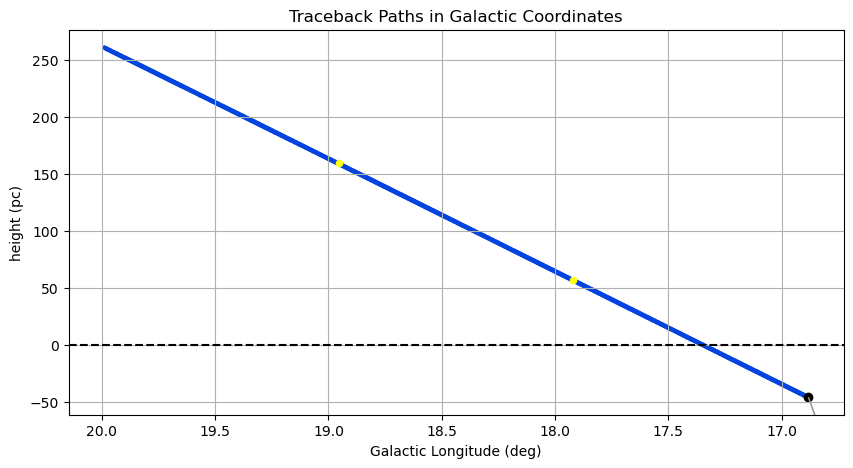

In [13]:
GalacticTraceback(x).plot_trace(savefig=False)

# Check with 1700-37

In [32]:
star_170037 =HMXB_trace[HMXB_trace['Name'] == 'HD 153919']
star_170037

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,SpType,Mod_SpType,SpColor,Mass_compact,M_compact_lower,M_compact_upper,Mass_companion,M_companion_lower,M_companion_upper,Name,Trace Time
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,mag,mag,mag,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,km / s,mas / yr,mas / yr,,,,,,,,,,,Million years
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,float64,float64,float64,float64,float64,float64,str23,float64
5976382915813535232,255.9865659301791,0.021049444,-37.8441202722809,0.012138224,2.4137032635492046,0.02806476,5.021949969731823,0.021347089,0.6327358617075665,0.025948899,nan,nan,6.4204698,347.75444710988126,2.173492429913019,6.5759535,6.0885863,0.48736715,1.5804383163952436,5.459355496184255,1.114173464609666,6.9646916981903955,221.52058975292903,-56.84609840595855,-2.079921136161054,-0.974954593248736,-0.333036617639879,0.052075832776272056,60.9160634716124,7.872313249985188,2.03705222508213,O6Iafcp,xkcd:blue,xkcd:blue,1.96,1.77,2.15,--,--,--,HD 153919,7.022759916857373


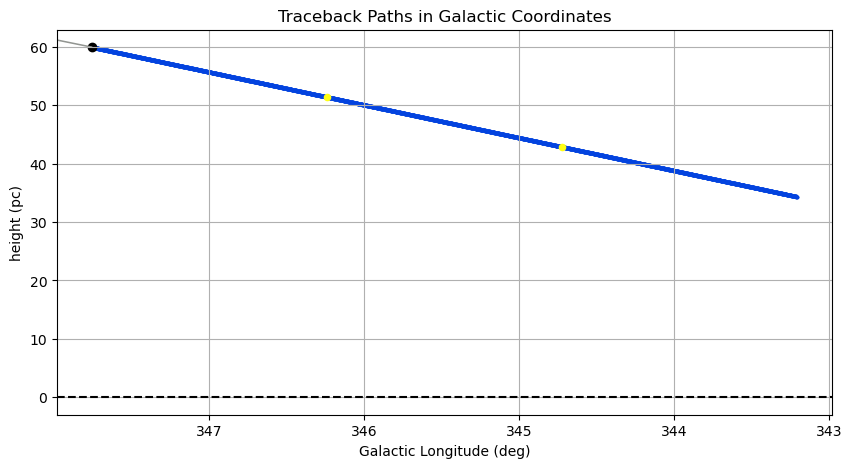

In [33]:
GalacticTraceback(star_170037).plot_trace(savefig=False)

# Converting astropy table list to float. Used in Galactic_traceback

very dumb

In [28]:
x = HMXB_sample[HMXB_sample['source_id'] == 427234969757165952]
#float(x['l'][0])
l = float(x['l'][0])
l


121.22141620023214

In [15]:
HMXB_sample = GalacticTraceback(HMXB_sample).traceback_time()

In [16]:
HMXB_trace = GalacticTraceback(HMXB_trace).traceback_time()

In [17]:
HMXB_trace.write(home_files+f"Trace_{today}.csv",format='ascii.csv',overwrite=True)

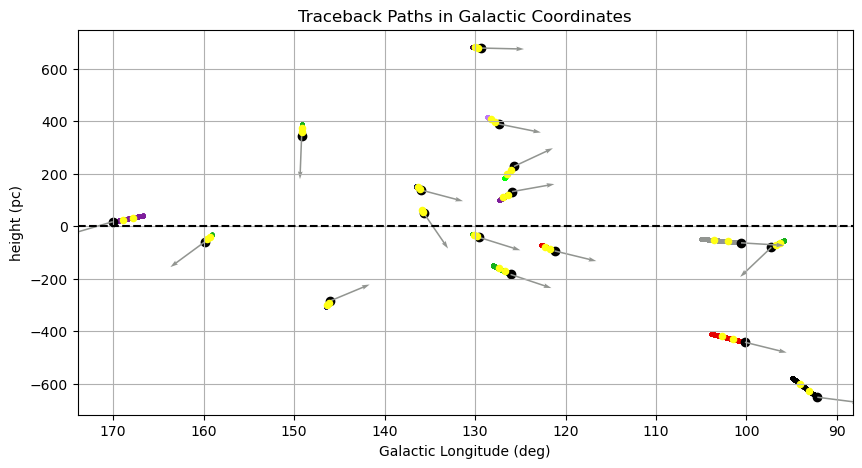

In [18]:
GalacticTraceback(HMXB_sample).plot_trace(savefig=False)

0 11


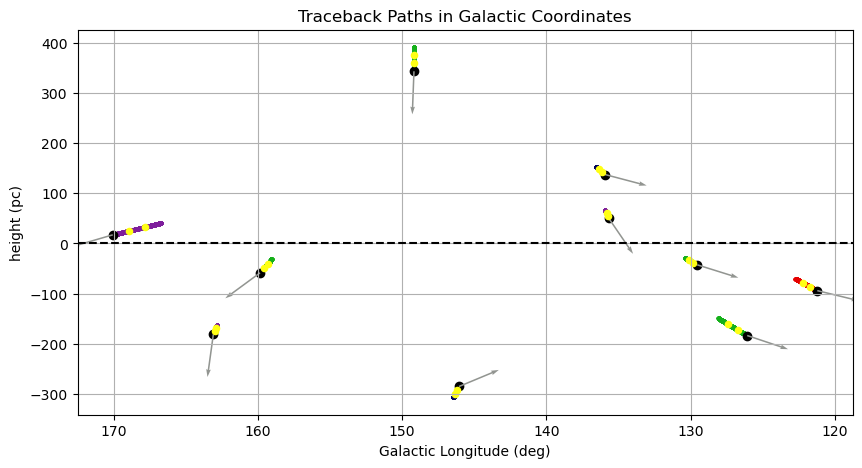

11 22


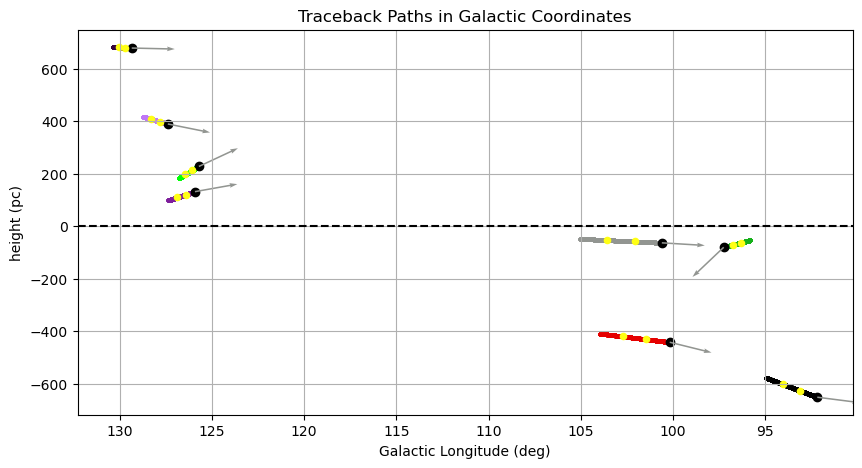

22 33


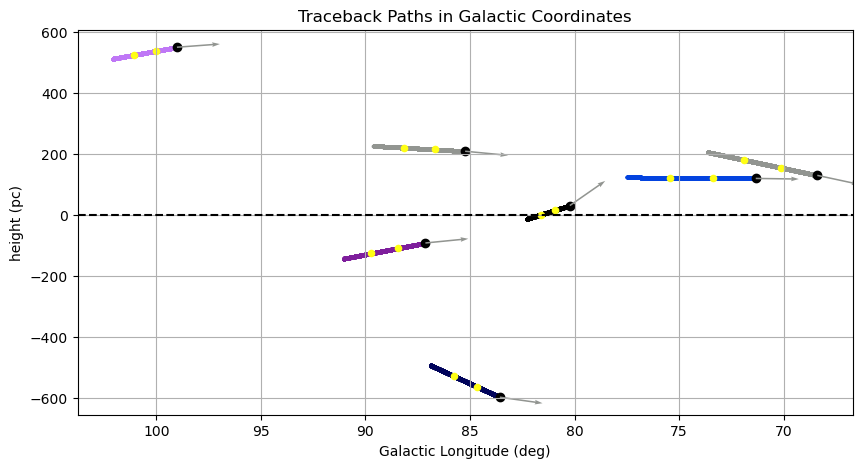

33 44


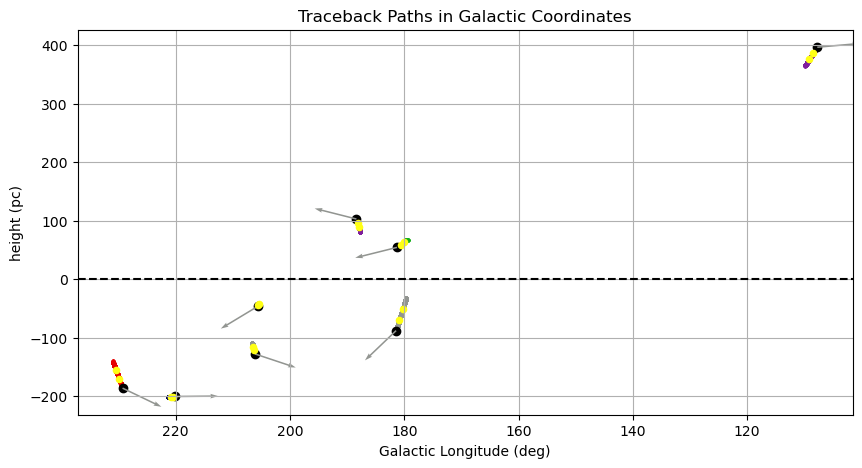

44 55


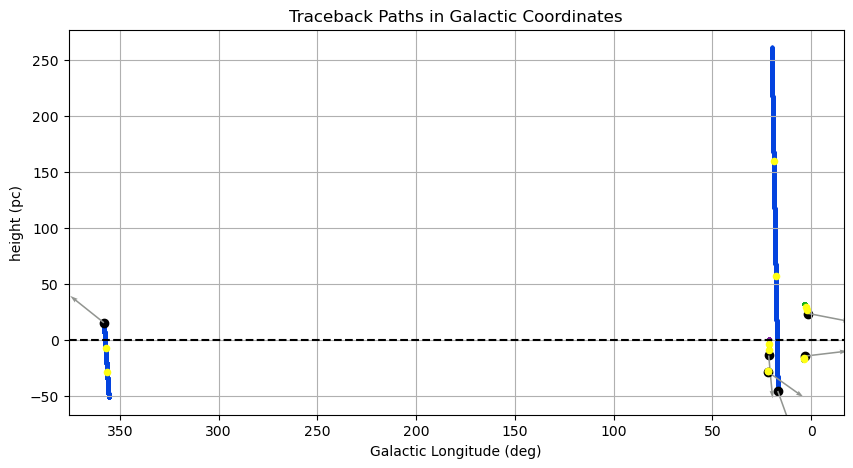

55 66


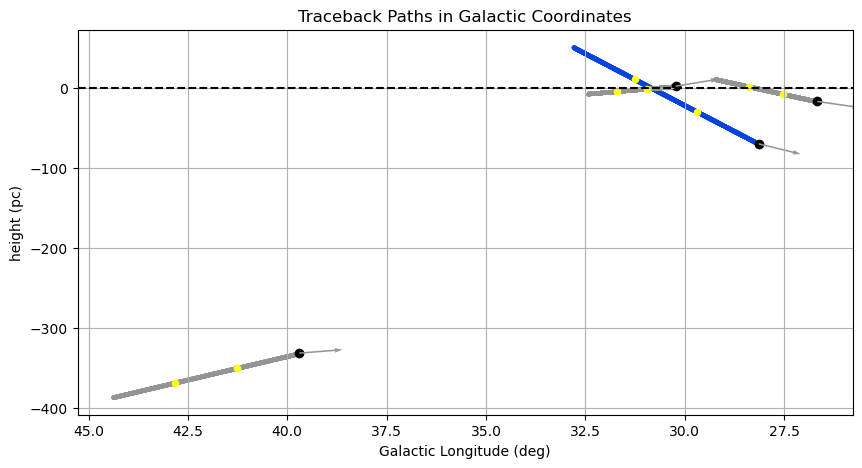

66 77


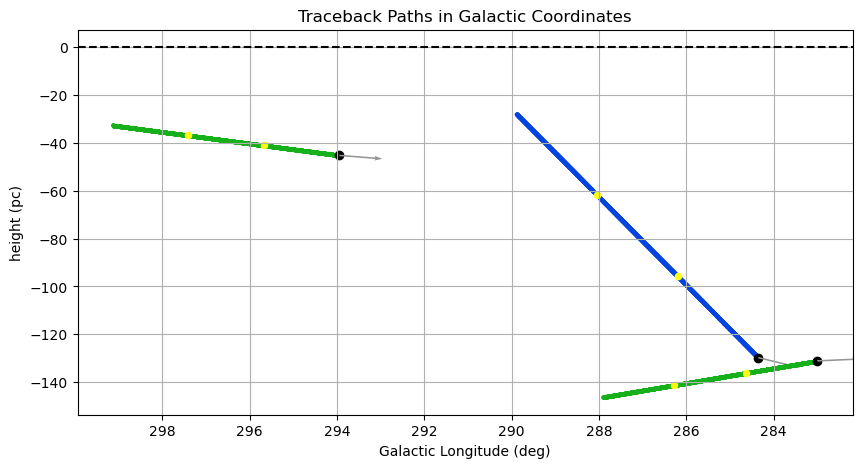

77 88


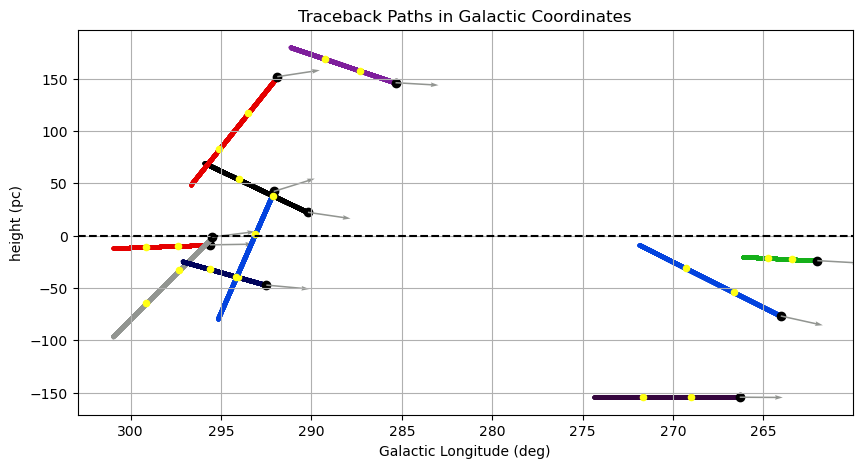

88 99


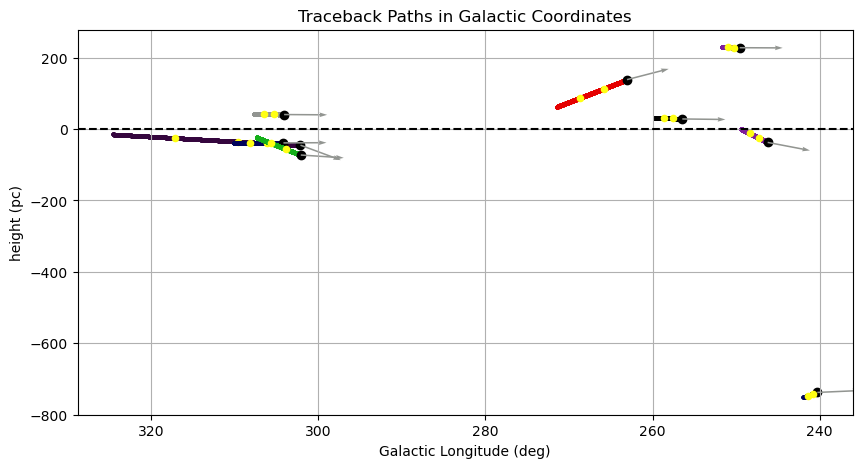

99 110


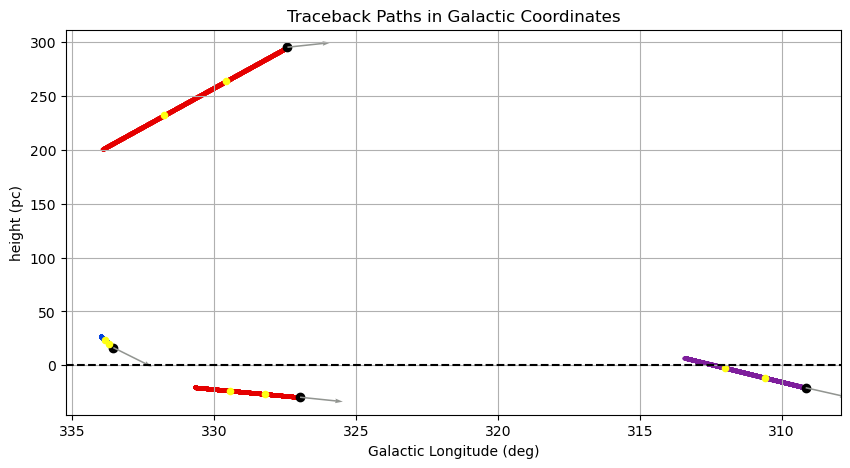

110 121


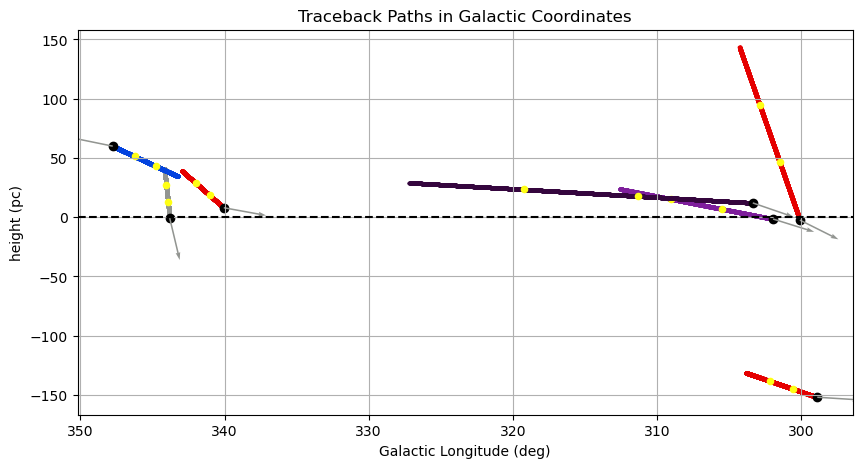

In [19]:
see_idx = np.linspace(0,121,12)
see_idx 

for i in range(len(see_idx)-1):
    a = int(see_idx[i])
    b = int(see_idx[i+1])
    print(a,b)
    GalacticTraceback(HMXB_trace[a:b]).plot_trace(savefig=False)
    

In [20]:
intersting_index = [5,9,14,16,35,42,47,74,105]
#for indexing subtract 2
intersting_index = [x -2 for x in intersting_index]
intersting_index
interesting_stars = HMXB_trace[intersting_index]

In [21]:
interesting_stars

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,SpType,Mod_SpType,SpColor,Mass_compact,M_compact_lower,M_compact_upper,Mass_companion,M_companion_lower,M_companion_upper,Name,Trace Time
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,mag,mag,mag,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,km / s,mas / yr,mas / yr,,,,,,,,,,,Million years
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,float64,float64,float64,float64,float64,float64,str23,float64
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,nan,nan,10.766115,149.17651611413766,4.133059262254314,11.439369,9.855047,1.584322,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.810032757999913,226.8654620531654,75.83556855602039,0.7629157021820535,-0.3433404950633777,-0.7985036619761263,0.12115839202699431,10.764396229063566,0.06229471894967609,-0.47301969013360023,B1/2I[e],xkcd:green,xkcd:green,--,--,--,--,--,--,XTE J0421+560,-21.402438098253675
444752973131169664,53.749629724978455,0.013929484,53.17313997828423,0.012730369,-0.26805266659388,0.019742586,0.4401283844933388,0.019827945,0.13434727271763658,0.020151323,nan,nan,14.200214,146.05208942276994,-2.1940257086354467,15.475269,13.086571,2.3886986,7.4433963546230135,-0.4757472370713855,0.19806512394601175,15.246797070152677,228.41658713708378,69.86204140982059,0.490706563956873,-0.21377081081802612,-0.7535385861904507,-0.05899033651392215,18.231124932309566,-0.21291521483780784,0.47082627127796006,O8-9Ve,xkcd:dark blue,xkcd:blue,--,--,--,--,--,--,V0332+53,-39.87826020920556
519352324516039680,23.95771733364349,0.0074431454,66.21202346679833,0.008329693,-1.6256635994947488,0.00863042,-0.02743521083805346,0.011114323,0.1668629279602417,0.01096499,nan,nan,12.461553,127.39442158128841,3.7256576059257593,13.468391,11.464951,2.0034409,5.9929429036404605,-1.5939762607956323,-0.32058463708656854,13.02898880860953,227.01595699116885,115.713542528705,0.5928061091307394,-0.2572658640502055,-1.9239415819148138,0.13897878241703096,9.421796865905847,-0.26284078801155797,-0.20229755545339398,B1Ve,xkcd:light purple,xkcd:green,--,--,--,--,--,--,IGR J01363+6610,-41.837211861499604
524924310153249920,19.511227046863358,0.0074612005,65.29162260285469,0.00889375,-1.2433985583085483,0.009154735,0.7606173957665759,0.011805355,0.1964171573898191,0.011268352,nan,nan,10.520529,125.70997540875491,2.563488419804798,11.247755,9.673886,1.5738688,5.091204929798221,-1.3209841517227512,0.6161003720529863,12.189584532266123,226.4251888125325,126.33418646431146,0.6923285413115551,-0.3058317902661893,-2.19541764484616,0.10021264014131061,20.31110987831015,0.1821049518118536,0.821719522177865,B1Iae,xkcd:bright green,xkcd:green,--,--,--,--,--,--,2S 0114+650,14.978985129558714
2201091578667140352,339.8368297959251,0.012457491,61.27405311885465,0.012111427,-2.344283875542537,0.015320877,-1.01527492097991,0.014133349,0.10398616408830161,0.013974317,nan,nan,14.104571,107.73443066473111,2.362332253415067,15.060287,13.122439,1.9378481,9.616663993402364,-2.5448550857789543,0.22397019150880831,14.639968887347397,228.053873036283,123.96618660365144,0.31655239007417124,-0.1578484501971588,-2.553231707016569,0.0794687601657688,19.679382764039776,-0.3081757688365565,0.3023498815401983,B0Ve,xkcd:purple,xkcd:green,--,--,--,--,--,--,SAX J2239.3+6116,37

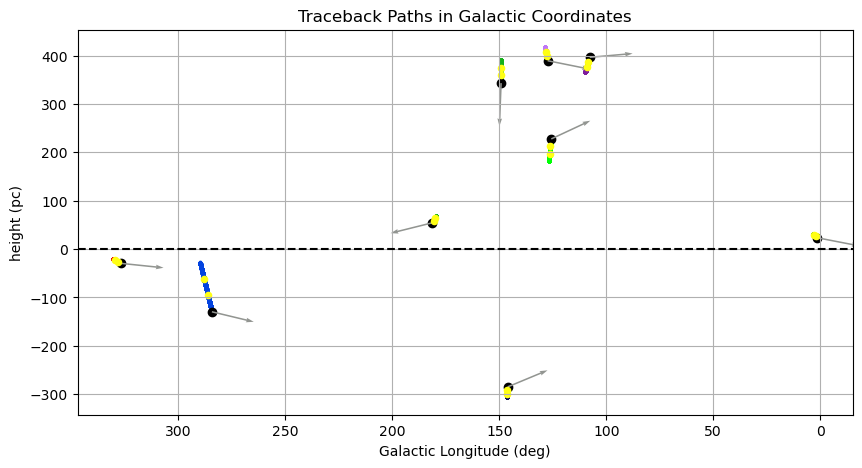

In [22]:
GalacticTraceback(interesting_stars).plot_trace(savefig=False)

In [23]:
HMXB_sample.write(home_files+"DATA/sample_path.csv",format='ascii.csv',overwrite=True)

In [24]:
leaving_stars_mask = HMXB_trace['Trace Time'] > 0
leaving_stars = HMXB_trace[leaving_stars_mask]
leaving_stars

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,SpType,Mod_SpType,SpColor,Mass_compact,M_compact_lower,M_compact_upper,Mass_companion,M_companion_lower,M_companion_upper,Name,Trace Time
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,mag,mag,mag,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,km / s,mas / yr,mas / yr,,,,,,,,,,,Million years
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,float64,float64,float64,float64,float64,float64,str23,float64
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,nan,nan,6.261697,163.0813533466715,-17.136203125538678,6.4398537,5.93006,0.50979376,0.6144760897364175,0.3095889769659371,-2.245323934218814,9.063394189676286,223.81506681128036,57.77572175230654,5.54632682187915,-1.8486200400580908,-0.4202484622115612,-0.4025983375739546,14.02859774983416,-4.8164893827016515,0.0058944434132315315,B0Ve,xkcd:purple,xkcd:green,--,--,--,--,--,--,4U 0352+309,27.475025011659326
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,nan,nan,10.403856,159.8470955000755,-1.2700235829277626,10.832097,9.790907,1.0411901,2.639752590095405,0.9593255549561471,-0.7047859211231655,11.015119773159219,225.5294017486117,59.20502188807201,1.3177498233849931,-0.597587187998077,-0.4438073449784902,-0.030656812265844154,1.434785114595448,0.08538307654964422,-0.07654192085924438,B0e,xkcd:green,xkcd:green,--,--,--,--,--,--,BSD 24-491,6.4871966954926545
414196617287885312,18.996040698840275,0.010982572,59.15394486765568,0.012779636,-2.4625832668630094,0.014893881,-0.546486466252775,0.016773285,0.3391933399322079,0.01803902,nan,nan,11.412056,126.08000772759438,-3.5676859152271287,11.667166,10.951165,0.71600056,2.9481710938070385,-2.3920245855272095,-0.800738525527853,10.505550935625854,225.1118353299879,145.18545631063174,1.197749379234627,-0.5634229362770962,-2.644620505556004,-0.1511493220972492,13.262661170839669,-0.9451534592058328,-0.08616626715350759,B1-2 III/Ve,xkcd:green,xkcd:green,--,--,--,--,--,--,TYC 3681-695-1,16.039779385350563
427234969757165952,9.290132580203235,0.008413794,61.36013319063004,0.009818237,-1.7956235405295953,0.010947091,-0.5251300483100196,0.013608978,0.27189066538368456,0.012059882,nan,nan,9.454656,121.22141620023214,-1.4641898756122689,9.768971,8.949126,0.8198452,3.677948996847052,-1.8178140519374264,-0.4422414945716403,10.870491734584071,225.41280416340064,148.84601654902679,0.934142743735759,-0.4446418257894607,-2.8427897106767976,-0.06013234426507411,1.922506718205155,0.09083291500361224,0.06253267548289451,BN0.5II-III / BN0.7Ib,xkcd:red,xkcd:red,--,--,--,--,--,--,IGR J00370+6122,11.919016231866244
511220031584305536,26.750875487648646,0.011500537,61.356572911514526,0.013774355,-1.029427556881088,0.01621835,-0.08166309914192828,0.016919507,0.32796283875254345,0.021653285,nan,nan,11.215371,129.54110404226162,-0.8001119868579849,11.629826,10.599628,1.0301971,3.0491259430600497,-0.9855121261320304,-0.30847334710531277,10.702430954822386,225.27542868600665,136.3058652913444,1.175325068529664,-0.5292864333891744,-2.3422924600071307,-0.033732762415593746,4.5179825629905,0.18145526534543643,0.25454584869945535,B1III-Ve,xkcd:green,xkcd:green,--,--,--,--,--,--,RX J0146.9+6121,

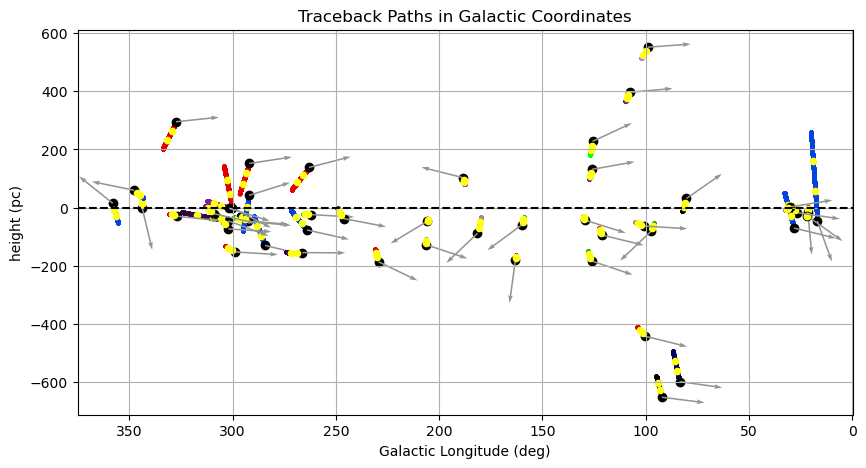

In [25]:
GalacticTraceback(leaving_stars).plot_trace(savefig=False)

In [26]:
approaching_stars_mask = HMXB_trace['Trace Time'] < 0
approaching_stars = HMXB_trace[approaching_stars_mask]

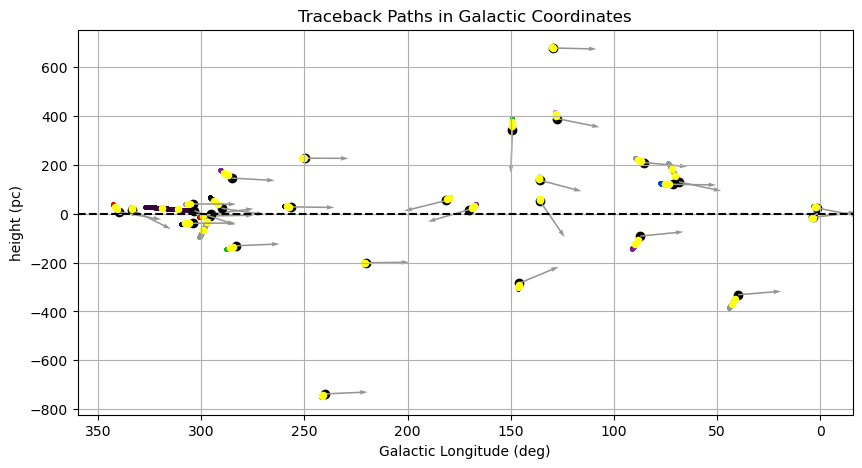

In [27]:
GalacticTraceback(approaching_stars).plot_trace(savefig=False)